<center><h1>Business Analytics Final Project</h1></center>
<center><h1>Predicting Order Cancelations With GG Taxi Data</h1></center>

<center><b>Team Members</b></center>
<center>Elen Vardanyan</center>
<center>Vahe Karapetyan</center>
<center>Lazr Galstyan</center>
<br>
<center><b>Professor</b></center>
<center>Hrant Davtyan</center>

## Data Cleaning

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [119]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
data = pd.read_csv('Downloads/GG_Data_All.csv')

As the data was exported from strings, the dates in the data were of class 'character'. So we converted it to a Pandas Timestamp object, which also took a lot of time. Here we include the time calculations as well.

In [151]:
%%time

data['created_at'] =  data['created_at'].map(lambda x: 
                                            pd.to_datetime(str(x).replace("'", ""), errors='coerce') + pd.Timedelta(hours=4))
data['accepted_at'] =  data['accepted_at'].map(lambda x: 
                                            pd.to_datetime(str(x).replace("'", ""), errors='coerce') + pd.Timedelta(hours=4))
data['arrived_at'] =  data['arrived_at'].map(lambda x: 
                                            pd.to_datetime(str(x).replace("'", ""), errors='coerce') + pd.Timedelta(hours=4))
data['processing_at'] =  data['processing_at'].map(lambda x: 
                                            pd.to_datetime(str(x).replace("'", ""), errors='coerce') + pd.Timedelta(hours=4))
data['completed_at'] =  data['completed_at'].map(lambda x: 
                                            pd.to_datetime(str(x).replace("'", ""), errors='coerce') + pd.Timedelta(hours=4))
data['canceled_at'] =  data['canceled_at'].map(lambda x: 
                                            pd.to_datetime(str(x).replace("'", ""), errors='coerce') + pd.Timedelta(hours=4))

CPU times: user 39min 1s, sys: 29.6 s, total: 39min 31s
Wall time: 41min 4s


In [101]:
data.columns = ['orderId', 'originLng', 'originLat', 'partnerId', 'userId', 'destLng', 
                'fare', 'distance', 'destLat', 'created_at', 'accepted_at', 'arrived_at', 
                'processing_at', 'completed_at', 'canceled_at']

Judging from the minima and maxima of the _longitude_ and _latitude_ columns, there are outliers. We decided not to use the statistical outlier detection methods, but instead we manually set some minimum and maximum numbers for these features.

In [102]:
data[['originLat', 'originLng']].describe()

,originLat,originLng
count,2.661633e+06,2.661633e+06
mean,4.021891e+01,4.450309e+01
std,3.077210e-01,6.289281e-01
min,-8.505090e+01,-1.799990e+02
25%,4.017840e+01,4.449450e+01
50%,4.019070e+01,4.451070e+01
75%,4.020450e+01,4.452230e+01
max,8.505110e+01,1.799980e+02


In [103]:
"The shape before: " + str(data.shape)

'The shape before: (2661633, 15)'

In [104]:
data = data[(data['originLat']<42) & (data['originLat']>38) & (data['originLng']<47) & (data['originLng']>43)]

In [105]:
"The shape after: " + str(data.shape)

'The shape after: (2660723, 15)'

In [153]:
data.to_hdf('gg_all.hdf5', 'gg')

## Feature Engineering

In [196]:
data = pd.read_hdf('gg_all.hdf5', 'gg')
data.head()

,orderId,originLng,originLat,partnerId,userId,destLng,fare,distance,destLat,created_at,accepted_at,arrived_at,processing_at,completed_at,canceled_at
0,330392,44.4419,40.1669,NaN,61715,NaN,NaN,NaN,NaN,2016-01-01 00:00:50,NaT,NaT,NaT,NaT,2016-01-01 00:01:04
1,330393,44.5266,40.2074,NaN,57214,NaN,NaN,NaN,NaN,2016-01-01 00:01:03,NaT,NaT,NaT,NaT,2016-01-01 00:01:07
2,330394,44.4708,40.2064,NaN,61840,NaN,NaN,NaN,NaN,2016-01-01 00:01:05,NaT,NaT,NaT,NaT,2016-01-01 00:01:08
3,330395,44.4391,40.1679,NaN,15026,NaN,NaN,NaN,NaN,2016-01-01 00:01:11,NaT,NaT,NaT,NaT,2016-01-01 00:05:46
4,330396,44.4887,40.1470,NaN,63831,NaN,NaN,NaN,NaN,2016-01-01 00:01:15,NaT,NaT,NaT,NaT,2016-01-01 00:05:47


We define a column next_stage_time which shows the seconds from the order creation to either acceptance or cancellation (whichever is available first).

In [109]:
data['next_stage_time'] = ""

accepted_isnull = np.where(data['accepted_at'].isnull())[0]
data['next_stage_time'][accepted_isnull] = (data['canceled_at'][accepted_isnull] - data['created_at'][accepted_isnull]).map(lambda x: x.total_seconds())

accepted_notnull = np.where(data['accepted_at'].notnull())[0]
data['next_stage_time'][accepted_notnull] = (data['accepted_at'][accepted_notnull] - data['created_at'][accepted_notnull]).map(lambda x: x.total_seconds())

We also exctract month, weekday, hour and season from the date of the order.

In [110]:
data['month'] = data['created_at'].map(lambda x: x.month)
data['weekday'] = data['created_at'].map(lambda x: x.weekday())
data['hour'] =  data['created_at'].map(lambda x: x.hour)
data['season'] = data['created_at'].apply(lambda dt: (dt.month%12 + 3)//3)

Scaling the numerical variables for better clustering and fitting.

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['originLng'], data['originLat'], data['next_stage_time'] = scaler.fit_transform(data[['originLng', 'originLat', 'next_stage_time']]).T

Clustering the (latitude, longitude) pairs into several regions.

In [114]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init='random', random_state=42)
data['region'] = kmeans.fit_predict(data[['originLng', 'originLat']])

In [115]:
data['region'].value_counts()

6    1001088
8     570557
2     294312
3     278501
4     221341
0     192139
5      47851
1      34106
9      18852
7       1976
Name: region, dtype: int64

Finally, making the column we have to predict.

In [116]:
data['canceled'] = data['canceled_at'].notnull()
data['canceled'].value_counts() / data.shape[0]

False    0.673516
True     0.326484
Name: canceled, dtype: float64

Dropping the values not needed for the prediction.

In [207]:
gg = data.drop(['userId', 'created_at', 'destLng', 'fare', 'distance', 'destLat', 'accepted_at', 'arrived_at', 'processing_at', 'completed_at', 'orderId', 'partnerId', 'canceled_at'], axis=1)
gg.head()

,originLng,originLat,next_stage_time,month,weekday,hour,season,region,canceled
0,-0.623732,-0.308702,-0.018727,Jan,Fri,0,Winter,0,True
1,0.206560,-0.067471,-0.022022,Jan,Fri,0,Winter,3,True
2,-0.340432,-0.073427,-0.022351,Jan,Fri,0,Winter,8,True
3,-0.651179,-0.302746,0.067273,Jan,Fri,0,Winter,0,True
4,-0.164963,-0.427233,0.066284,Jan,Fri,0,Winter,2,True


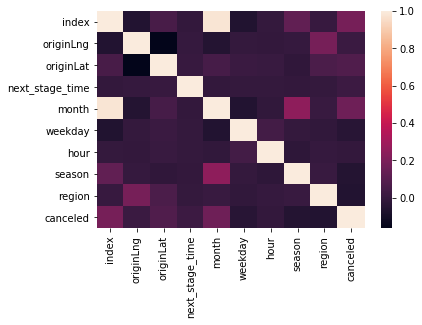

In [122]:
sns.heatmap(gg.corr())

Replacing the date numbers to strings will be helpful when we construct dummies.

In [123]:
weekday = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
season = {1:"Winter", 2:"Spring", 3:"Summer", 4:"Fall"}
month = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}


gg['weekday'] = gg['weekday'].replace(weekday)
gg['season'] = gg['season'].replace(season)
gg['month'] = gg['month'].replace(month)

In [155]:
gg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660723 entries, 0 to 2660722
Data columns (total 9 columns):
originLng          float64
originLat          float64
next_stage_time    float64
month              object
weekday            object
hour               int64
season             object
region             int64
canceled           bool
dtypes: bool(1), float64(3), int64(2), object(3)
memory usage: 164.9+ MB


In [156]:
gg.to_csv("final_data.csv", index=False)

## Visualizations

Text(0.5,1,'Distribution of locations of canceled orders')

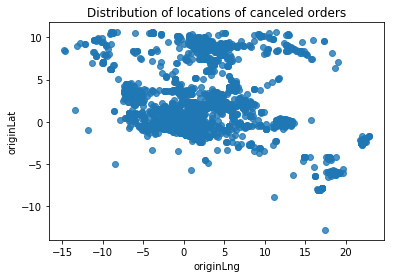

In [125]:
sns.regplot(x=gg["originLng"], y=gg["originLat"], fit_reg=False)
plt.title("Distribution of locations of canceled orders")
plt.show()

Text(0.5,1,'Percentage of canceled orders by Weekday')

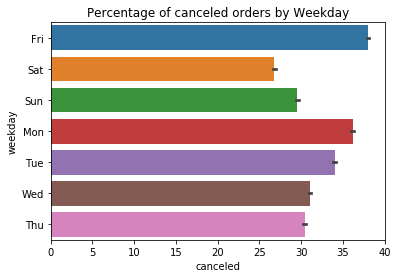

In [126]:
sns.barplot(x=gg.canceled*100, y=gg.weekday)
plt.title("Percentage of canceled orders by Weekday")
plt.show()

Text(0.5,1,'Percentage of cancelled orders by Month')

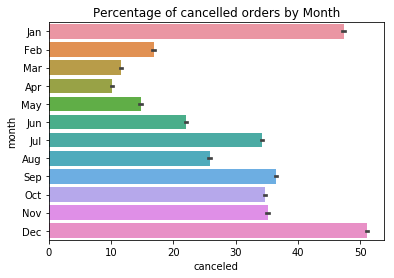

In [127]:
sns.barplot(x=gg.canceled*100, y=gg.month)
plt.title("Percentage of cancelled orders by Month")
plt.show()

Text(0.5,1,'Percentage of cancelled orders by season')

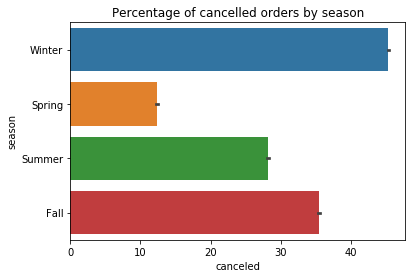

In [129]:
sns.barplot(x=gg.canceled*100, y=gg.season)
plt.title("Percentage of cancelled orders by season")
plt.show()

## Predictions

Creating Training and Test sets.

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [132]:
"Train baseline accuracy: " + str(accuracy_score(y_train, np.zeros(len(y_train))))
"Test baseline accuracy:  " + str(accuracy_score(y_test, np.zeros(len(y_test))))

'Train baseline accuracy: 0.6761664347629303'

'Test baseline accuracy:  0.6770424404941133'

In [133]:
"Train baseline AUC score: " + str(roc_auc_score(y_train, np.zeros(len(y_train))))
"Test baseline AUC score:  " + str(roc_auc_score(y_test, np.zeros(len(y_test))))

'Train baseline AUC score: 0.5'

'Test baseline AUC score:  0.5'

All of the models we used need numerical inputs, so we convert the categorical variables to dummies.

In [167]:
months = pd.get_dummies(gg['month'])
weekdays = pd.get_dummies(gg['weekday'])
seasons = pd.get_dummies(gg['season'])
regions = pd.get_dummies(gg['region'])

gg = gg.drop(['month', 'weekday', 'season', 'region'], axis=1)
gg = gg.join(months).join(weekdays).join(seasons).join(regions)

In [168]:
X = gg.drop('canceled', axis=1)
y = gg['canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
y_train.value_counts()
y_test.value_counts()

False    1433228
True      695350
Name: canceled, dtype: int64

False    358811
True     173334
Name: canceled, dtype: int64

### Logistic Regression

In [137]:
from sklearn.linear_model import LogisticRegression

In [170]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [171]:
"Accuracy for training set is " + str(logreg.score(X_train, y_train))
"Accuracy for test set is " + str(logreg.score(X_test, y_test))

'Accuracy for training set is 0.7639043530469638'

'Accuracy for test set is 0.7636903475556475'

In [173]:
"AUC for the training set is " + str(roc_auc_score(y_train, logreg.predict(X_train)))
"AUC for the test set is " + str(roc_auc_score(y_test, logreg.predict(X_test)))

'AUC for the training set is 0.6699314721959811'

'AUC for the test set is 0.6690620753004926'

In [174]:
print(classification_report(y_test, logreg.predict(X_test)))

             precision    recall  f1-score   support

      False       0.76      0.94      0.84    358811
       True       0.76      0.40      0.52    173334

avg / total       0.76      0.76      0.74    532145



### Gradient Boosting

In [175]:
from sklearn.ensemble import GradientBoostingClassifier

In [176]:
xgb = GradientBoostingClassifier(max_depth=10, random_state=42)
xgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [177]:
"Accuracy for training set is " + str(xgb.score(X_train, y_train))
"Accuracy for test set is " + str(xgb.score(X_test, y_test))

'Accuracy for training set is 0.8346774231435259'

'Accuracy for test set is 0.8260135865224704'

In [178]:
"AUC for the training set is " + str(roc_auc_score(y_train, xgb.predict(X_train)))
"AUC for the test set is " + str(roc_auc_score(y_test, xgb.predict(X_test)))

'AUC for the training set is 0.8109272943981547'

'AUC for the test set is 0.801104187320767'

In [179]:
print(classification_report(y_test, xgb.predict(X_test)))

             precision    recall  f1-score   support

      False       0.87      0.87      0.87    358811
       True       0.73      0.73      0.73    173334

avg / total       0.83      0.83      0.83    532145



## Neural Network

In [197]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard

n_cols = X_train.shape[1]

model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_training = model.fit(X_train, y_train, validation_split=0.1, epochs=20, callbacks=[EarlyStopping(patience=4), TensorBoard()])

Train on 1915720 samples, validate on 212858 samples
Epoch 1/20
1915720/1915720 [==============================] - 108s 56us/step - loss: 0.4526 - acc: 0.7963 - val_loss: 0.4342 - val_acc: 0.8071
Epoch 2/20
1915720/1915720 [==============================] - 109s 57us/step - loss: 0.4332 - acc: 0.8079 - val_loss: 0.4441 - val_acc: 0.8016
Epoch 3/20
1915720/1915720 [==============================] - 108s 57us/step - loss: 0.4295 - acc: 0.8093 - val_loss: 0.4273 - val_acc: 0.8105
Epoch 4/20
1915720/1915720 [==============================] - 109s 57us/step - loss: 0.4273 - acc: 0.8105 - val_loss: 0.4339 - val_acc: 0.8072
Epoch 5/20
1915720/1915720 [==============================] - 109s 57us/step - loss: 0.4259 - acc: 0.8111 - val_loss: 0.4261 - val_acc: 0.8110
Epoch 6/20
1915720/1915720 [==============================] - 109s 57us/step - loss: 0.4250 - acc: 0.8115 - val_loss: 0.4260 - val_acc: 0.8104
Epoch 7/20
1915720/1915720 [==============================] - 110s 57us/step - loss: 0.42

In [199]:
pred_train = model.predict_classes(X_train)
"Accuracy for train set is " + str(accuracy_score(y_train, pred_train))
"AUC for the train set is " + str(roc_auc_score(y_train, pred_train))

'Accuracy for train set is 0.8131639996279206'

'AUC for the train set is 0.7880649968359897'

In [200]:
pred_test = model.predict_classes(X_test)
"Accuracy for test set is " + str(accuracy_score(y_test, pred_test))
"AUC for the test set is " + str(roc_auc_score(y_test, pred_test))

'Accuracy for test set is 0.8117054562196394'

'AUC for the test set is 0.7859835278554017'